# Multi-objective adjoint optimization

In this notebook, we will show how to use autograd efficiently for objectives involving several simulations.

One common application of this involves defining an objective function that may depend on several different definitions of your structures, each with some geometric or material modification. For example, including the performance of devices with slightly larger or smaller feature sizes into one's objective can serve to make optimization more robust to fabrication errors. For more details, see this [paper](https://link.springer.com/article/10.1007/s10409-009-0240-z). 

In [ ]:
import autograd as ag
import autograd.numpy as anp
import matplotlib.pylab as plt
import tidy3d as td
import tidy3d.web as web

### Setup

First, let's define the frequency that our objective will depend on

In [2]:
freq0 = 2e14
wavelength = td.C_0 / freq0

Now we set up some physical parameters.

We will be putting a `td.Box` in the center of a domain with a point source on one side and a diffraction monitor on the other.

The objective will involve summing the power of the 0th order diffraction order.

The gradient of this objective will be computed with respect to the permittivity of the box.

We will adjust the size of the box by `dy` in the y direction and define a combined objective function that returns the average power when the box is either perturbed by `+dy`, `0`, or `-dy`, which emulates a treatment for enhancing device robustness via dilation and erosion effects, as described in the paper linked at the top of this notebook.

In [3]:
permittivity_val = 2.0

# box sizes (original design)
lx = wavelength
ly = wavelength
lz = wavelength

# amount by which we will change the box size in y
dy = ly / 5.0

buffer = 2 * wavelength

Lx = lx + 2 * buffer
Ly = ly + dy + 2 * buffer
Lz = lz + 2 * buffer


src_pos_x = -Lx / 2 + buffer / 2
mnt_pos_x = +Lx / 2 - buffer / 2

In [4]:
def make_sim(permittivity: float, dy_sign: int) -> td.Simulation:
    """Make a simulation as a function of the box permittivity and the frequency."""

    box_size = ly + dy_sign * dy

    box = td.Structure(
        geometry=td.Box(center=(0.0, 0.0, 0.0), size=(lx, box_size, lz)),
        medium=td.Medium(permittivity=permittivity),
    )

    src = td.PointDipole(
        center=(src_pos_x, 0, 0),
        polarization="Ey",
        source_time=td.GaussianPulse(
            freq0=freq0,
            fwidth=freq0 / 10,
        ),
    )

    mnt = td.DiffractionMonitor(
        center=(mnt_pos_x, 0, 0),
        size=(0, td.inf, td.inf),
        freqs=[freq0],
        name="diffraction",
    )

    return td.Simulation(
        size=(Lx, Ly, Lz),
        structures=[box],
        monitors=[mnt],
        sources=[src],
        grid_spec=td.GridSpec.auto(wavelength=td.C_0 / freq0),
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(), y=td.Boundary.periodic(), z=td.Boundary.periodic()
        ),
        run_time=200 / src.source_time.fwidth,
    )

Let's make a simulation for each of the perturbed size values and visualize them.

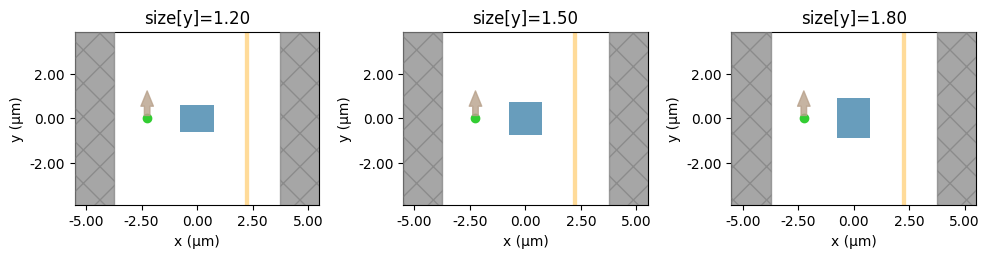

In [5]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 4))

for ax, dy_sign in zip(axes, (-1, 0, 1)):
    sim = make_sim(permittivity=permittivity_val, dy_sign=dy_sign)
    ax = sim.plot(z=0, ax=ax)
    ax.set_title(f"size[y]={sim.structures[0].geometry.size[1]:.2f}")

### Define Objective

Now let's define our objective function, first we defined how to postprocess a `SimulationData` to give the desired power.

In [6]:
def post_process(sim_data: td.SimulationData) -> float:
    """O-th order diffracted power."""
    amp = sim_data["diffraction"].amps.sel(orders_x=0, orders_y=0).values
    return anp.sum(anp.abs(amp) ** 2)

And then we write our combined, multi-objective over all of the `dy` values.  We use the `web.run` function to run a list of these three simulations simultaneously.

In [7]:
def objective(permittivity: float) -> float:
    """Average of O-th order diffracted power over all dy_sign values."""
    sims = {f"sign = {dy_sign}": make_sim(permittivity, dy_sign=dy_sign) for dy_sign in (-1, 0, 1)}

    batch_data = web.run(sims, path="data", verbose=True)

    power = sum(post_process(sim_data) for sim_data in batch_data.values()) / len(batch_data)
    return power

### Multi-Objective Gradient Calculation

Finally, we are ready to use `ag.value_and_grad` to differentiate this function.

In [8]:
grad_objective = ag.value_and_grad(objective)

power_average, grad_power_min = grad_objective(permittivity_val)
print(f"average power = {power_average:.2e}")
print(f"derivative of average power wrt permittivity = {grad_power_min:.2e}")

Output()

Output()

Output()

Output()

Output()

12:20:19 CEST Started working on Batch containing 3 tasks.

12:20:22 CEST Maximum FlexCredit cost: 0.075 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

12:22:42 CEST Batch complete.

Output()

12:22:50 CEST Started working on Batch containing 3 tasks.

12:22:55 CEST Maximum FlexCredit cost: 0.075 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

12:23:10 CEST Batch complete.

Output()

Output()

Output()

average power = 2.64e+00
derivative of average power wrt permittivity = -8.47e-01


### Sanity Checking: Manual Loop over size

Now we will implement the brute force approach to computing the multi-objective gradient by the naive approach of looping over dy values and computing the individual gradient contributions one by one.

In [ ]:
def grad_manual(permittivity: float) -> float:
    """Average of O-th order diffracted power over all dy_sign values."""

    grad_avg = 0.0

    for dy_sign in (-1, 0, 1):
        print(f"working on dy_sign = {dy_sign}")

        def objective_fn(p, dy_sign=dy_sign):
            sim = make_sim(p, dy_sign=dy_sign)
            sim_data = td.web.run(sim, task_name=f"dy_sign={dy_sign}", verbose=False)
            return post_process(sim_data)

        grad_fn = ag.grad(objective_fn)

        gradient = grad_fn(permittivity)
        grad_avg += gradient / 3.0

    return grad_avg

In [10]:
grad_man = grad_manual(permittivity_val)

working on dy_sign = -1
working on dy_sign = 0
working on dy_sign = 1


We can see that they match, as expected.

In [11]:
print(f"gradient (batched) = {grad_power_min:.4e}")
print(f"gradient (looped) = {grad_man:.4e}")

gradient (batched) = -8.4677e-01
gradient (looped) = -8.4677e-01


## Takeaways

The main thing to note here is that, using `web.run`, all of the individual simulations were uploaded at roughly the same time.

This means that the server is able to work on them concurrently rather than needing to wait for the previously uploaded one to finish. The time savings for applications with several simulations can be enormous.
